<a href="https://colab.research.google.com/github/jedhouas/Digraph/blob/master/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [0]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve
import re
import numpy.linalg as linalg

In [0]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

FileNotFoundError: ignored

# 1) Monolingual (English) word embeddings 

In [0]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        # Returns 0 if words doesn't exist in self.words
        if word in self.words:
            return(self.embeddings[self.word2id[word]])
        else:
            return(np.zeros(300))
        raise NotImplementedError('Fill in the blank')
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        vec1 = self.encode(word1)
        vec2 = self.encode(word2)
        return(np.dot(vec1.T,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
        raise NotImplementedError('Fill in the blank')
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        scores=[self.score(word,vocab) for vocab in self.words]
        sorted_scores=np.flip(np.argsort(scores,axis=None))
        return [self.id2word[idx] for idx in sorted_scores[1:k+1]] # Not including the biggest score (argscore = 0) because it should be the word itself
        raise NotImplementedError('Fill in the blank')

In [0]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [0]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        d = defaultdict(float)
        for sentence in sentences:
            words=np.unique([word for word in re.sub(r'\W+', ' ', sentence).split()])
            for word in words:
                d[word]+=1
        D=len(sentences)
        idf={k:np.log(D/v) for k,v in d.items()}
        return idf
        raise NotImplementedError('Fill in the blank')
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        w = np.unique([word for word in re.sub(r'\W+', ' ', sentence).split()])
        res = np.zeros(300)
        s = 0
        if idf is None:
            # mean of word vectors
            for word in w:
                if word in self.word2vec.words:
                    res = res + self.word2vec.encode(word)
                    s = s + 1
            if s == 0:
                return(res)
            else:
                return((1/s)*res)
            raise NotImplementedError('Fill in the blank')
        else:
            # idf-weighted mean of word vectors
            for word in w:
                if (word in self.word2vec.words) and (word in idf.keys()):
                    res = res + idf[word]*self.word2vec.encode(word)
                    s = s + idf[word]
            if s == 0:
                return(res)
            else:
                return((1/s)*res)
            raise NotImplementedError('Fill in the blank')

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm
        vec1 = self.encode(sentence1)
        vec2 = self.encode(sentence2)
        return(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
        raise NotImplementedError('Fill in the blank')
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        scores=[self.score(sentence, sent, idf) for sent in sentences]
        sorted_scores=np.flip(np.argsort(scores,axis=None))
        return [sentences[idx] for idx in sorted_scores[0:k]]
        raise NotImplementedError('Fill in the blank')

In [0]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6545625066602266
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) 3 males and 1 woman enjoying a sporting event 
5) 2 chinese people wearing traditional clothes 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6545625066602266
2 chinese people wearing traditional clothes 
1) 2 chinese people wearing traditional clothes 
2) 2 woman dancing while pointing . 
3) 3 security woman with sunglasses walking 
4) 2 people fighting with training swords 
5) 2 female babies eating chips . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [0]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        commun_words = list(set(self.fr_word2vec.words).intersection(self.en_word2vec.words))
        X = np.vstack(self.fr_word2vec.encode(word) for word in commun_words).T
        Y = np.vstack(self.en_word2vec.encode(word) for word in commun_words).T
        #raise NotImplementedError('Fill in the blank')
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, S, VT = np.linalg.svd(Y.dot(X.T))
        W = U.dot(VT)
        #raise NotImplementedError('Fill in the blank')
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        fr_emb = self.get_aligned_fr_embeddings()[self.fr_word2vec.word2id[fr_word]]
        scores=[np.dot(fr_emb.T,en_emb)/(np.linalg.norm(fr_emb)*np.linalg.norm(en_emb)) for en_emb in self.en_word2vec.embeddings]
        sorted_scores=np.flip(np.argsort(scores,axis=None))
        return [self.en_word2vec.id2word[idx] for idx in sorted_scores[0:k]]
        raise NotImplementedError('Fill in the blank')

In [0]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


/Users/jedhouas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
/Users/jedhouas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [0]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
sst_train_path = PATH_TO_DATA / 'SST/stsa.fine.train'
sst_dev_path = PATH_TO_DATA / 'SST/stsa.fine.dev'
sst_test_path = PATH_TO_DATA / 'SST/stsa.fine.test.X'
with open(sst_train_path, 'r') as f:
    sst_train_sentences = [line.strip('\n') for line in f]
with open(sst_dev_path, 'r') as f:
    sst_dev_sentences = [line.strip('\n') for line in f]
with open(sst_test_path, 'r') as f:
    sst_test_sentences = [line.strip('\n') for line in f]

def read_raw(raw):
    sentences = []
    labels = []
    for line in raw:
        label, sentence = line.split(" ", 1)
        sentences.append(sentence)
        labels.append(int(label))
    return sentences, labels

f = open(PATH_TO_DATA/ 'SST/stsa.fine.train')
sst_train_raw = f.readlines()
f.close()
f = open(PATH_TO_DATA/ 'SST/stsa.fine.dev')
sst_dev_raw = f.readlines()
f.close()
f = open(PATH_TO_DATA/ 'SST/stsa.fine.test.X')
sst_test = f.readlines()
f.close()

sst_train, label_train = read_raw(sst_train_raw)
sst_dev, label_dev = read_raw(sst_dev_raw)

sst_train_sentences = [x.strip('\n') for x in sst_train]
sst_dev_sentences = [x.strip('\n') for x in sst_dev]
sst_test_sentences = [x.strip('\n') for x in sst_test]

In [0]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)
bov_train_idf = []
bov_dev_idf = []
bov_test_idf = []
bov_train_mean = []
bov_dev_mean = []
bov_test_mean = []
idf_sst = sentence2vec.build_idf(sst_train_sentences + sst_dev_sentences + sst_test_sentences)
for sent in sst_train_sentences:
    bov_train_idf.append(sentence2vec.encode(sent, idf_sst))
for sent in sst_dev_sentences:
    bov_dev_idf.append(sentence2vec.encode(sent, idf_sst))
for sent in sst_test_sentences:
    bov_test_idf.append(sentence2vec.encode(sent, idf_sst))
for sent in sst_train_sentences:
    bov_train_mean.append(sentence2vec.encode(sent, idf=None))
for sent in sst_dev_sentences:
    bov_dev_mean.append(sentence2vec.encode(sent, idf=None))
for sent in sst_test_sentences:
    bov_test_mean.append(sentence2vec.encode(sent, idf=None))
    

Loaded 50000 pretrained word vectors


Best BoV-mean accuracy : 0.4087193460490463
Best BoV-idf accuracy : 0.4178019981834696


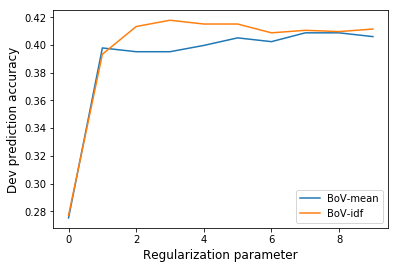

In [0]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Parameter selection without idf
Cs = np.linspace(1e-3, 8, 10)
accuracy_mean = []
for C in Cs:
    classifier = LogisticRegression(penalty="l2", C=C, solver="liblinear", multi_class='ovr', tol=1e-6)
    classifier.fit(bov_train_mean, label_train)
    prediction = classifier.predict(bov_dev_mean)
    accuracy = np.mean(prediction == label_dev)
    accuracy_mean.append(accuracy)

# Parameter selection with idf
accuracy_idf = []
for C in Cs:
    classifier = LogisticRegression(penalty="l2", C=C, solver="liblinear", multi_class='ovr', tol=1e-6)
    classifier.fit(bov_train_idf, label_train)
    prediction = classifier.predict(bov_dev_idf)
    accuracy = np.mean(prediction == label_dev)
    accuracy_idf.append(accuracy)

C_mean = Cs[np.argmax(accuracy_mean)]
C_idf = Cs[np.argmax(accuracy_mean)]

print("Best BoV-mean accuracy : {}".format(max(accuracy_mean)))
print("Best BoV-idf accuracy : {}".format(max(accuracy_idf)))
plt.plot(accuracy_mean, label="BoV-mean")
plt.plot(accuracy_idf, label="BoV-idf")
plt.xlabel("Regularization parameter", fontsize=12)
plt.ylabel("Dev prediction accuracy", fontsize=12)
plt.legend()
plt.show()

In [0]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
best_classifier = LogisticRegression(penalty="l2", C=C_mean, solver="liblinear", multi_class='ovr', tol=1e-6)
best_classifier.fit(bov_train_idf, label_train)
prediction_test = best_classifier.predict(bov_test_mean)
text_to_write = "\n".join(prediction_test.astype(str))
f = open("logreg_bov_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

In [0]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
import xgboost as xgb

classifier_xgb_mean = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, n_jobs=4)
classifier_xgb_mean.fit(np.vstack(bov_train_mean), label_train)
prediction_mean = classifier_xgb_mean.predict(bov_dev_mean)
accuracy_mean = np.mean(prediction_mean == label_dev)
print("XGBoost bov-mean accuracy : {}".format(accuracy_mean))

classifier_xgb_idf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, n_jobs=4)
classifier_xgb_idf.fit(np.vstack(bov_train_idf), label_train)
prediction_idf = classifier_xgb_idf.predict(bov_dev_idf)
accuracy_idf = np.mean(prediction_idf == label_dev)
print("XGBoost bov-idf accuracy : {}".format(accuracy_idf))

# We take bov-mean, which is better
prediction_test = classifier_xgb_mean.predict(bov_test_mean)
text_to_write = "\n".join(prediction_test.astype(str))
f = open("xgb_bov_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

/Users/jedhouas/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost bov-mean accuracy : 0.3887375113533152


/Users/jedhouas/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost bov-idf accuracy : 0.3960036330608538


/Users/jedhouas/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [0]:
import tensorflow as tf
import tensorflow.keras.utils as utils

In [0]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
def one_hot_array(array):
    res = []
    for sentence in array:
        res.append(tf.keras.preprocessing.text.one_hot(sentence, n=50000))
    return res

x_train = one_hot_array(sst_train_sentences)
x_dev = one_hot_array(sst_dev_sentences)
x_test = one_hot_array(sst_test_sentences)
y_train = utils.to_categorical(label_train)
y_dev = utils.to_categorical(label_dev)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=52)
x_dev = tf.keras.preprocessing.sequence.pad_sequences(x_dev, maxlen=52)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=52)

## 4.2 - Design and train your model

In [0]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 70  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

In [0]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adagrad' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 70)                103880    
_________________________________________________________________
dense (Dense)                (None, 5)                 355       
Total params: 15,104,235
Trainable params: 15,104,235
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 7

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/7
8544/8544 [==============================] - 111s 13ms/sample - loss: 1.5805 - accuracy: 0.2827 - val_loss: 1.5707 - val_accuracy: 0.2879
Epoch 2/7
8544/8544 [==============================] - 89s 10ms/sample - loss: 1.5567 - accuracy: 0.3249 - val_loss: 1.5641 - val_accuracy: 0.2916
Epoch 3/7
5568/8544 [==================>...........] - ETA: 22s - loss: 1.5452 - accuracy: 0.3488

KeyboardInterrupt: 

In [0]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_test_pred = model.predict(x_test)
y_test_pred = y_test_pred.argmax(axis=1)
text_to_write = "\n".join(y_test_pred.astype(str))
f = open("logreg_lstm_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

In [0]:
import matplotlib.pyplot as plt
X1 = history.history["accuracy"]
X2 = history.history["val_accuracy"]
plt.plot(X1, label="Train accuracy")
plt.plot(X2, label="Dev accuracy")
plt.legend()
plt.show()

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Dev accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Dev loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 4.3 - innovate !

In [0]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE